In [153]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.decomposition import PCA
import math
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
from gurobipy import Model, GRB, quicksum

In [154]:
warnings.filterwarnings('ignore')

In [155]:
def read_csv():
    
    # 2021-2022 season
    df_2021_2022 = pd.read_csv('2021_2022.csv', encoding='ISO-8859-1')
    df_2021_2022[["Rk", "Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]] = df_2021_2022['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'].str.split(';', expand=True)
    df_2021_2022 = df_2021_2022.drop(['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'], axis=1)
    
    # 2022-2023 season
    df_2022_2023 = pd.read_csv('2022_2023.csv', encoding='ISO-8859-1')
    df_2022_2023[["Rk", "Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]] = df_2022_2023['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'].str.split(';', expand=True)
    df_2022_2023 = df_2022_2023.drop(['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'], axis=1)

    # 2023-2024 season
    df_2023_2024 = pd.read_csv('2023_2024.csv', encoding='ISO-8859-1')
    df_2023_2024[["Rk", "Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]] = df_2023_2024['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'].str.split(';', expand=True)
    df_2023_2024 = df_2023_2024.drop(['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'], axis=1)
    
    # Yahoo player list
    df_yahoo = pd.read_csv('Yahoo_Player_List.csv')
    
    return df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo

In [156]:
df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo = read_csv()

In [157]:
def dataframe_cleaning(df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo):
    
    # 2021-2022 season dropping duplicates
    df_mask = df_2021_2022.drop_duplicates(subset=['Player'], keep='last')
    df_mask = df_mask[["Player", "Tm"]]
    
    df_2021_2022 = df_2021_2022.drop_duplicates(subset=['Player'], keep='first')
    df_2021_2022 = df_2021_2022.drop(["Tm"], axis=1)
    
    df_2021_2022 = pd.merge(df_2021_2022, df_mask, on=['Player'], how="left")
    
    df_2021_2022 = df_2021_2022.drop(["Rk"], axis=1)
    
    df_2021_2022 = df_2021_2022.sort_values(by='Player', ascending=True, ignore_index=True)

    # 2022-2023 season dropping duplicates
    df_mask = df_2022_2023.drop_duplicates(subset=['Player'], keep='last')
    df_mask = df_mask[["Player", "Tm"]]
    
    df_2022_2023 = df_2022_2023.drop_duplicates(subset=['Player'], keep='first')
    df_2022_2023 = df_2022_2023.drop(["Tm"], axis=1)
    
    df_2022_2023 = pd.merge(df_2022_2023, df_mask, on=['Player'], how="left")
    
    df_2022_2023 = df_2022_2023.drop(["Rk"], axis=1)
    
    df_2022_2023 = df_2022_2023.sort_values(by='Player', ascending=True, ignore_index=True)
    
    # 2023-2024 season dropping duplicates
    df_mask = df_2023_2024.drop_duplicates(subset=['Player'], keep='last')
    df_mask = df_mask[["Player", "Tm"]]
    
    df_2023_2024 = df_2023_2024.drop_duplicates(subset=['Player'], keep='first')
    df_2023_2024 = df_2023_2024.drop(["Tm"], axis=1)
    
    df_2023_2024 = pd.merge(df_2023_2024, df_mask, on=['Player'], how="left")
    
    df_2023_2024 = df_2023_2024.drop(["Rk"], axis=1)
    
    df_2023_2024 = df_2023_2024.sort_values(by='Player', ascending=True, ignore_index=True)
    
    # Yahoo players and positions
    df_yahoo["Player"] = df_yahoo['First Name'] + " " + df_yahoo['Last Name']
    
    df_yahoo = df_yahoo.drop(["ID", "OR", "Last Name", "First Name", "Team", "Status", "Status Details", "Image", 
                              "Avg. Pick", "Avg. Round", "Avg. Cost", "% Drafted", "FG%", "FT%", "3PTM", "PTS", 
                              "REB", "AST", "ST", "BLK", "TO"], axis=1)
    
    df_yahoo = df_yahoo.sort_values(by='Player', ascending=True, ignore_index=True)
    
    # 2021-2022 season % statistics
    df_2021_2022['FG%'] = df_2021_2022['FG%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2021_2022['3P%'] = df_2021_2022['3P%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2021_2022['2P%'] = df_2021_2022['2P%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2021_2022['eFG%'] = df_2021_2022['eFG%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2021_2022['FT%'] = df_2021_2022['FT%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    
    # 2022-2023 season % statistics
    df_2022_2023['FG%'] = df_2022_2023['FG%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2022_2023['3P%'] = df_2022_2023['3P%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2022_2023['2P%'] = df_2022_2023['2P%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2022_2023['eFG%'] = df_2022_2023['eFG%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2022_2023['FT%'] = df_2022_2023['FT%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    
    # 2023-2024 season % statistics
    df_2023_2024['FG%'] = df_2023_2024['FG%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2023_2024['3P%'] = df_2023_2024['3P%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2023_2024['2P%'] = df_2023_2024['2P%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2023_2024['eFG%'] = df_2023_2024['eFG%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    df_2023_2024['FT%'] = df_2023_2024['FT%'].astype(str).apply(lambda x: x if (len(x) == 1 or "." in x) else '.' + x)
    
    return df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo

In [158]:
df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo = dataframe_cleaning(df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo)

In [159]:
def combining_dataframes(df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo):
    
    # 2021-2022 season 
    df_2021_2022 = df_2021_2022.rename(columns={'G': 'G 21/22', 'GS': 'GS 21/22', 'MP': 'MP 21/22', 'FG': 'FG 21/22', 
                                                'FGA': 'FGA 21/22', 'FG%': 'FG% 21/22', '3P': '3P 21/22', '3PA': '3PA 21/22', 
                                                '3P%': '3P% 21/22', '2P': '2P 21/22', '2PA': '2PA 21/22', '2P%': '2P% 21/22', 
                                                'eFG%': 'eFG% 21/22', 'FT': 'FT 21/22', 'FTA': 'FTA 21/22', 'FT%': 'FT% 21/22', 
                                                'ORB': 'ORB 21/22', 'DRB': 'DRB 21/22', 'TRB': 'TRB 21/22', 'AST': 'AST 21/22', 
                                                'STL': 'STL 21/22', 'BLK': 'BLK 21/22', 'TOV': 'TOV 21/22', 'PF': 'PF 21/22', 
                                                'PTS': 'PTS 21/22'})
    
    df_2021_2022 = df_2021_2022.drop(["Pos", "Age", "Tm"], axis=1)
    
    # 2022-2023 season 
    df_2022_2023 = df_2022_2023.rename(columns={'G': 'G 22/23', 'GS': 'GS 22/23', 'MP': 'MP 22/23', 'FG': 'FG 22/23', 
                                                'FGA': 'FGA 22/23', 'FG%': 'FG% 22/23', '3P': '3P 22/23', '3PA': '3PA 22/23', 
                                                '3P%': '3P% 22/23', '2P': '2P 22/23', '2PA': '2PA 22/23', '2P%': '2P% 22/23', 
                                                'eFG%': 'eFG% 22/23', 'FT': 'FT 22/23', 'FTA': 'FTA 22/23', 'FT%': 'FT% 22/23', 
                                                'ORB': 'ORB 22/23', 'DRB': 'DRB 22/23', 'TRB': 'TRB 22/23', 'AST': 'AST 22/23', 
                                                'STL': 'STL 22/23', 'BLK': 'BLK 22/23', 'TOV': 'TOV 22/23', 'PF': 'PF 22/23', 
                                                'PTS': 'PTS 22/23'})
    
    df_2022_2023 = df_2022_2023.drop(["Pos", "Age", "Tm"], axis=1)
    
    # 2023-2024 season 
    df_2023_2024 = df_2023_2024.rename(columns={'G': 'G 23/24', 'GS': 'GS 23/24', 'MP': 'MP 23/24', 'FG': 'FG 23/24', 
                                                'FGA': 'FGA 23/24', 'FG%': 'FG% 23/24', '3P': '3P 23/24', '3PA': '3PA 23/24', 
                                                '3P%': '3P% 23/24', '2P': '2P 23/24', '2PA': '2PA 23/24', '2P%': '2P% 23/24', 
                                                'eFG%': 'eFG% 23/24', 'FT': 'FT 23/24', 'FTA': 'FTA 23/24', 'FT%': 'FT% 23/24', 
                                                'ORB': 'ORB 23/24', 'DRB': 'DRB 23/24', 'TRB': 'TRB 23/24', 'AST': 'AST 23/24', 
                                                'STL': 'STL 23/24', 'BLK': 'BLK 23/24', 'TOV': 'TOV 23/24', 'PF': 'PF 23/24', 
                                                'PTS': 'PTS 23/24'})
    
    # Combining dataframes
    df_player_statistics = pd.merge(df_2021_2022, df_2022_2023, on=['Player'], how="outer")
    df_player_statistics = pd.merge(df_player_statistics, df_2023_2024, on=['Player'], how="outer")
    
    # Fixing the player names and positions
    df_player_statistics = df_player_statistics.replace("A.J. Green", "AJ Green")
    df_player_statistics = df_player_statistics.replace("Boban Marjanovi?", "Boban Marjanovic")
    df_player_statistics = df_player_statistics.replace("Bogdan Bogdanovi?", "Bogdan Bogdanovic")
    df_player_statistics = df_player_statistics.replace("Bojan Bogdanovi?", "Bojan Bogdanovic")
    df_player_statistics = df_player_statistics.replace("Jonas Valan?i?nas", "Jonas Valanciunas")
    df_player_statistics = df_player_statistics.replace("Jusuf Nurki?", "Jusuf Nurkic")
    df_player_statistics = df_player_statistics.replace("Kristaps Porzi??is", "Kristaps Porzingis")
    df_player_statistics = df_player_statistics.replace("Luka Don?i?", "Luka Doncic")
    df_player_statistics = df_player_statistics.replace("Luka amani?", "Luka Samanic")
    df_player_statistics = df_player_statistics.replace("Nikola Joki?", "Nikola Jokic")
    df_player_statistics = df_player_statistics.replace("Nikola Jovi?", "Nikola Jovic")
    df_player_statistics = df_player_statistics.replace("Nikola Vu?evi?", "Nikola Vucevic")
    df_player_statistics = df_player_statistics.replace("Vasilije Mici?", "Vasilije Micic")
    df_player_statistics = df_player_statistics.replace("Théo Maledon", "Theo Maledon")
    df_player_statistics = df_player_statistics.replace("Mãozinha Pereira", "Maozinha Pereira")
    df_player_statistics = df_player_statistics.replace("Moussa Diabaté", "Moussa Diabate")
    df_player_statistics = df_player_statistics.replace("Dennis Schröder", "Dennis Schroder")
    df_player_statistics = df_player_statistics.replace("Dario ari?", "Dario Saric")
    df_player_statistics = df_player_statistics.replace("P.J. Washington", "P.J. Washington Jr.")
    df_player_statistics = df_player_statistics.replace("Robert Williams", "Robert Williams III")
    
    df_player_statistics = df_player_statistics.drop(["Pos"], axis=1)
    df_player_statistics = pd.merge(df_player_statistics, df_yahoo, on=['Player'], how="right")
    
    return df_player_statistics

In [160]:
df_player_statistics = combining_dataframes(df_2021_2022, df_2022_2023, df_2023_2024, df_yahoo)

In [161]:
# Store the dataframes
%store df_player_statistics
%store df_2021_2022
%store df_2022_2023
%store df_2023_2024
%store df_yahoo

Stored 'df_player_statistics' (DataFrame)
Stored 'df_2021_2022' (DataFrame)
Stored 'df_2022_2023' (DataFrame)
Stored 'df_2023_2024' (DataFrame)
Stored 'df_yahoo' (DataFrame)


In [162]:
# Helper method
def combination(alist):
    if len(alist) == 0:
        return [[]]
    
    combinations = []
    
    for c in combination(alist[1:]):
        combinations += [c, c+[alist[0]]]
        
    return combinations

In [163]:
def correlation_between_categories(df_2023_2024):
    
    # Selecting columns 
    df_2023_2024 = df_2023_2024[["PTS", "TRB", "AST", "3P", "FT%", "FG%", "TOV", "STL", "BLK"]]
    
    # Converting datatypes
    df_2023_2024["PTS"] = pd.to_numeric(df_2023_2024["PTS"])
    df_2023_2024["TRB"] = pd.to_numeric(df_2023_2024["TRB"])
    df_2023_2024["AST"] = pd.to_numeric(df_2023_2024["AST"])
    df_2023_2024["3P"] = pd.to_numeric(df_2023_2024["3P"])
    df_2023_2024["FT%"] = pd.to_numeric(df_2023_2024["FT%"])
    df_2023_2024["FG%"] = pd.to_numeric(df_2023_2024["FG%"])
    df_2023_2024["TOV"] = pd.to_numeric(df_2023_2024["TOV"])
    df_2023_2024["STL"] = pd.to_numeric(df_2023_2024["STL"])
    df_2023_2024["BLK"] = pd.to_numeric(df_2023_2024["BLK"])
    
    df_2023_2024_corr = df_2023_2024.corr()
    
    # Correlation dictionary
    corr_dict = df_2023_2024_corr.to_dict()
    corr_dict = {key: {inner_key: corr_dict[key][inner_key] for inner_key in corr_dict[key]} for key in corr_dict}

    for i in corr_dict:
        for j in corr_dict:
            if (i == "TOV" or j == "TOV"):
                corr_dict[i][j] = -corr_dict[i][j]
    
    category_list = ["FG%", "FT%", "3P", "PTS", "TRB", "AST", "STL", "BLK", "TOV"]
    
    five_category_list = [i for i in combination(category_list) if len(i) == 5]
    five_category_dict = {}
    
    for i in five_category_list:
        five_category_dict[str(i).strip("[]")] = 0
    
    for i in five_category_dict:
        k = i.split(", ")
        k = [i.strip("'") for i in k]
        k_filtered = [i for i in combination(k) if len(i) == 2]
        for j in k_filtered:
            five_category_dict[i] += corr_dict[j[0]][j[1]]
    
    alist = []

    for i in five_category_dict:
        alist.append([i, five_category_dict[i]])
    
    alist.sort(key=lambda x: x[1])
    
    return alist[-1]

In [164]:
correlation_between_categories(df_2023_2024)

["'STL', 'AST', 'TRB', 'PTS', '3P'", 5.886925037799221]

In [165]:
def yahoo_league_analysis():
    
    # Week to week matchup
    df_matchup = pd.read_csv('Yahoo_Matchup_List.csv')
    df_matchup = df_matchup.drop(["Team 1 ID", "Team 2 ID", "Playoff", "Consolation", "Complete", "Team 1 Name", "Team 2 Name", "Week"], axis=1)
    
    # Win count dictionary
    for column in df_matchup:
        df_matchup[column] = pd.to_numeric(df_matchup[column])
    
    result_dict = {}
    
    category_list = ["FG%", "FT%", "3PTM", "PTS", "REB", "AST", "ST", "BLK", "TO"]
    
    five_category_list = [i for i in combination(category_list) if len(i) == 5]
    five_category_dict = {}
    
    for i in five_category_list:
        five_category_dict[str(i).strip("[]")] = 0
    
    for i in df_matchup.index:
        if (df_matchup["Team 1 Points"][i] > df_matchup["Team 2 Points"][i]):
            for j in five_category_dict:
                jlist = j.split(", ")
                jlist = [i.strip("'") for i in jlist]
                if "TO" not in jlist:
                    if (df_matchup["Team 1 " + jlist[0]][i] > df_matchup["Team 2 " + jlist[0]][i] 
                    and df_matchup["Team 1 " + jlist[1]][i] > df_matchup["Team 2 " + jlist[1]][i] 
                    and df_matchup["Team 1 " + jlist[2]][i] > df_matchup["Team 2 " + jlist[2]][i] 
                    and df_matchup["Team 1 " + jlist[3]][i] > df_matchup["Team 2 " + jlist[3]][i] 
                    and df_matchup["Team 1 " + jlist[4]][i] > df_matchup["Team 2 " + jlist[4]][i]): 
                        five_category_dict[j] += 1 
                else:
                    to_index = jlist.index('TO')
                    temp = jlist[0]
                    jlist[0] = jlist[to_index]
                    jlist[to_index] = temp
                    if (df_matchup["Team 1 " + jlist[0]][i] < df_matchup["Team 2 " + jlist[0]][i] 
                    and df_matchup["Team 1 " + jlist[1]][i] > df_matchup["Team 2 " + jlist[1]][i] 
                    and df_matchup["Team 1 " + jlist[2]][i] > df_matchup["Team 2 " + jlist[2]][i] 
                    and df_matchup["Team 1 " + jlist[3]][i] > df_matchup["Team 2 " + jlist[3]][i] 
                    and df_matchup["Team 1 " + jlist[4]][i] > df_matchup["Team 2 " + jlist[4]][i]): 
                        five_category_dict[j] += 1 
        elif (df_matchup["Team 1 Points"][i] < df_matchup["Team 2 Points"][i]):
            for j in five_category_dict:
                jlist = j.split(", ")
                jlist = [i.strip("'") for i in jlist]
                if "TO" not in jlist:
                    if (df_matchup["Team 1 " + jlist[0]][i] < df_matchup["Team 2 " + jlist[0]][i] 
                    and df_matchup["Team 1 " + jlist[1]][i] < df_matchup["Team 2 " + jlist[1]][i] 
                    and df_matchup["Team 1 " + jlist[2]][i] < df_matchup["Team 2 " + jlist[2]][i] 
                    and df_matchup["Team 1 " + jlist[3]][i] < df_matchup["Team 2 " + jlist[3]][i] 
                    and df_matchup["Team 1 " + jlist[4]][i] < df_matchup["Team 2 " + jlist[4]][i]): 
                        five_category_dict[j] += 1 
                else:
                    to_index = jlist.index('TO')
                    temp = jlist[0]
                    jlist[0] = jlist[to_index]
                    jlist[to_index] = temp
                    if (df_matchup["Team 1 " + jlist[0]][i] > df_matchup["Team 2 " + jlist[0]][i] 
                    and df_matchup["Team 1 " + jlist[1]][i] < df_matchup["Team 2 " + jlist[1]][i] 
                    and df_matchup["Team 1 " + jlist[2]][i] < df_matchup["Team 2 " + jlist[2]][i] 
                    and df_matchup["Team 1 " + jlist[3]][i] < df_matchup["Team 2 " + jlist[3]][i] 
                    and df_matchup["Team 1 " + jlist[4]][i] < df_matchup["Team 2 " + jlist[4]][i]): 
                        five_category_dict[j] += 1 
                        
    alist = []

    for i in five_category_dict:
        alist.append([i, five_category_dict[i]])
    
    alist.sort(key=lambda x: x[1])
    
    return alist[-1]

In [166]:
yahoo_league_analysis()

["'ST', 'AST', 'REB', 'PTS', '3PTM'", 28]

In [167]:
def top_200_default(df_2023_2024):
    
    # Fixing player names
    df_2023_2024 = df_2023_2024.replace("A.J. Green", "AJ Green")
    df_2023_2024 = df_2023_2024.replace("Boban Marjanovi?", "Boban Marjanovic")
    df_2023_2024 = df_2023_2024.replace("Bogdan Bogdanovi?", "Bogdan Bogdanovic")
    df_2023_2024 = df_2023_2024.replace("Bojan Bogdanovi?", "Bojan Bogdanovic")
    df_2023_2024 = df_2023_2024.replace("Jonas Valan?i?nas", "Jonas Valanciunas")
    df_2023_2024 = df_2023_2024.replace("Jusuf Nurki?", "Jusuf Nurkic")
    df_2023_2024 = df_2023_2024.replace("Kristaps Porzi??is", "Kristaps Porzingis")
    df_2023_2024 = df_2023_2024.replace("Luka Don?i?", "Luka Doncic")
    df_2023_2024 = df_2023_2024.replace("Luka amani?", "Luka Samanic")
    df_2023_2024 = df_2023_2024.replace("Nikola Joki?", "Nikola Jokic")
    df_2023_2024 = df_2023_2024.replace("Nikola Jovi?", "Nikola Jovic")
    df_2023_2024 = df_2023_2024.replace("Nikola Vu?evi?", "Nikola Vucevic")
    df_2023_2024 = df_2023_2024.replace("Vasilije Mici?", "Vasilije Micic")
    df_2023_2024 = df_2023_2024.replace("Théo Maledon", "Theo Maledon")
    df_2023_2024 = df_2023_2024.replace("Mãozinha Pereira", "Maozinha Pereira")
    df_2023_2024 = df_2023_2024.replace("Moussa Diabaté", "Moussa Diabate")
    df_2023_2024 = df_2023_2024.replace("Dennis Schröder", "Dennis Schroder")
    df_2023_2024 = df_2023_2024.replace("Dario ari?", "Dario Saric")
    df_2023_2024 = df_2023_2024.replace("P.J. Washington", "P.J. Washington Jr.")
    df_2023_2024 = df_2023_2024.replace("Robert Williams", "Robert Williams III")

    # Empty dataframe
    df_zscores = pd.DataFrame({})
    
    # Selecting columns
    df_2023_2024 = df_2023_2024[["Player", "PTS", "TRB", "AST", "3P", "FT%", "FG%", "TOV", "STL", "BLK", "FTA", "FGA"]]
    
    # Converting datatypes
    df_2023_2024["PTS"] = pd.to_numeric(df_2023_2024["PTS"])
    df_2023_2024["TRB"] = pd.to_numeric(df_2023_2024["TRB"])
    df_2023_2024["AST"] = pd.to_numeric(df_2023_2024["AST"])
    df_2023_2024["3P"] = pd.to_numeric(df_2023_2024["3P"])
    df_2023_2024["FT%"] = pd.to_numeric(df_2023_2024["FT%"])
    df_2023_2024["FG%"] = pd.to_numeric(df_2023_2024["FG%"])
    df_2023_2024["TOV"] = pd.to_numeric(df_2023_2024["TOV"])
    df_2023_2024["STL"] = pd.to_numeric(df_2023_2024["STL"])
    df_2023_2024["BLK"] = pd.to_numeric(df_2023_2024["BLK"])
    df_2023_2024["FTA"] = pd.to_numeric(df_2023_2024["FTA"])
    df_2023_2024["FGA"] = pd.to_numeric(df_2023_2024["FGA"])
    df_zscores["FTA"] = df_2023_2024["FTA"]
    df_zscores["FGA"] = df_2023_2024["FGA"]
    df_zscores["PTS"] = df_2023_2024["PTS"]
    df_zscores["TRB"] = df_2023_2024["TRB"]
    df_zscores["AST"] = df_2023_2024["AST"]
    df_zscores["3P"] = df_2023_2024["3P"]
    df_zscores["STL"] = df_2023_2024["STL"]
    df_zscores["BLK"] = df_2023_2024["BLK"]
    df_zscores["FT%"] = df_2023_2024["FT%"]
    df_zscores["FG%"] = df_2023_2024["FG%"]
    df_zscores["TOV"] = df_2023_2024["TOV"]
    
    # Accounting for attempts
    ft_attempts_mean = np.average(df_2023_2024["FTA"])
    fg_attempts_mean = np.average(df_2023_2024["FGA"])
    
    df_2023_2024["FT Ratio"] = (df_2023_2024["FTA"]/ft_attempts_mean)
    df_2023_2024["FG Ratio"] = (df_2023_2024["FGA"]/fg_attempts_mean)
    
    # Calculate the means
    pts_mean = np.average(df_2023_2024["PTS"].dropna())
    reb_mean = np.average(df_2023_2024["TRB"].dropna())
    ast_mean = np.average(df_2023_2024["AST"].dropna())
    tp_mean = np.average(df_2023_2024["3P"].dropna())
    stl_mean = np.average(df_2023_2024["STL"].dropna())
    blk_mean = np.average(df_2023_2024["BLK"].dropna())
    ft_mean = np.average(df_2023_2024["FT%"].dropna())
    fg_mean = np.average(df_2023_2024["FG%"].dropna())
    to_mean = np.average(df_2023_2024["TOV"].dropna())

    # Calculate the stds
    pts_std = np.std(df_2023_2024["PTS"].dropna())
    reb_std = np.std(df_2023_2024["TRB"].dropna())
    ast_std = np.std(df_2023_2024["AST"].dropna())
    tp_std = np.std(df_2023_2024["3P"].dropna())
    stl_std = np.std(df_2023_2024["STL"].dropna())
    blk_std = np.std(df_2023_2024["BLK"].dropna())
    ft_std = np.std(df_2023_2024["FT%"].dropna())
    fg_std = np.std(df_2023_2024["FG%"].dropna())
    to_std = np.std(df_2023_2024["TOV"].dropna())
    
    # Calculate the z-scores
    df_zscores["Player"] = df_2023_2024["Player"]
    df_zscores["PTS Z-Score"] = (df_2023_2024["PTS"] - pts_mean) / pts_std
    df_zscores["TRB Z-Score"] = (df_2023_2024["TRB"] - reb_mean) / reb_std
    df_zscores["AST Z-Score"] = (df_2023_2024["AST"] - ast_mean) / ast_std
    df_zscores["3P Z-Score"] = (df_2023_2024["3P"] - tp_mean) / tp_std
    df_zscores["STL Z-Score"] = (df_2023_2024["STL"] - stl_mean) / stl_std
    df_zscores["BLK Z-Score"] = (df_2023_2024["BLK"] - blk_mean) / blk_std
    df_zscores["FT% Z-Score"] = (df_2023_2024["FT Ratio"])*(df_2023_2024["FT%"] - ft_mean) / ft_std
    df_zscores["FG% Z-Score"] = (df_2023_2024["FG Ratio"])*(df_2023_2024["FG%"] - fg_mean) / fg_std
    df_zscores["TOV Z-Score"] = (df_2023_2024["TOV"] - to_mean) / to_std
    
    # 0.25 Weight on Turnovers
    df_zscores["TOV Z-Score"] = -(df_zscores["TOV Z-Score"])
    df_zscores['TOV Z-Score'] = df_zscores['TOV Z-Score'] * 0.25
    
    # Total z-scores
    df_zscores["Total Z-Score"] = df_zscores["PTS Z-Score"] + df_zscores["TRB Z-Score"] + df_zscores["AST Z-Score"] + df_zscores["3P Z-Score"]+ df_zscores["STL Z-Score"]+ df_zscores["BLK Z-Score"]+ df_zscores["FT% Z-Score"]+ df_zscores["FG% Z-Score"]+ df_zscores["TOV Z-Score"]
    
    df_zscores = df_zscores.sort_values(by='Total Z-Score', ascending=False, ignore_index=True)   
    
    df_top_200 = df_zscores[:200]
    
    return df_top_200

In [168]:
df_top_200 = top_200_default(df_2023_2024)

In [169]:
def injury_analysis(df_player_statistics):
    
    # Selecting columns
    df_injury = df_player_statistics[["Player", "G 21/22", "G 22/23", "G 23/24"]]
    
    df_injury["G 21/22"] = pd.to_numeric(df_injury["G 21/22"])
    df_injury["G 22/23"] = pd.to_numeric(df_injury["G 22/23"])
    df_injury["G 23/24"] = pd.to_numeric(df_injury["G 23/24"])
    
    # Creating average games played column
    df_injury['Average Games Played'] = (df_injury[["G 21/22", "G 22/23", "G 23/24"]].mean(axis=1))/82
    
    return df_injury

In [170]:
df_injury = injury_analysis(df_player_statistics)

In [171]:
def top_200_correlated(df_top_200, df_injury):
    
    # New dataframe
    df_zscores_200 = pd.DataFrame({})

    # Calculate the means
    pts_mean = np.average(df_top_200["PTS"].dropna())
    reb_mean = np.average(df_top_200["TRB"].dropna())
    ast_mean = np.average(df_top_200["AST"].dropna())
    tp_mean = np.average(df_top_200["3P"].dropna())
    stl_mean = np.average(df_top_200["STL"].dropna())

    # Calculate the stds
    pts_std = np.std(df_top_200["PTS"].dropna())
    reb_std = np.std(df_top_200["TRB"].dropna())
    ast_std = np.std(df_top_200["AST"].dropna())
    tp_std = np.std(df_top_200["3P"].dropna())
    stl_std = np.std(df_top_200["STL"].dropna())

    # Calculate the z-scores
    df_zscores_200["Player"] = df_top_200["Player"]
    df_zscores_200["PTS Z-Score"] = (df_top_200["PTS"] - pts_mean) / pts_std
    df_zscores_200["TRB Z-Score"] = (df_top_200["TRB"] - reb_mean) / reb_std
    df_zscores_200["AST Z-Score"] = (df_top_200["AST"] - ast_mean) / ast_std
    df_zscores_200["3P Z-Score"] = (df_top_200["3P"] - tp_mean) / tp_std
    df_zscores_200["STL Z-Score"] = (df_top_200["STL"] - stl_mean) / stl_std
    
    # Combining dataframes
    df_zscores_200 = pd.merge(df_zscores_200, df_injury[["Player", "Average Games Played"]], on=['Player'], how="left")
    
    return df_zscores_200

In [172]:
df_zscores_200 = top_200_correlated(df_top_200, df_injury)

In [173]:
def categorical_weights(df_top_200):
    
    # Mean rostered compared to mean waiver
    df_top_156 = df_top_200[:156]
    
    pts_mean_rostered = np.average(df_top_156["PTS"].dropna())
    reb_mean_rostered = np.average(df_top_156["TRB"].dropna())
    ast_mean_rostered = np.average(df_top_156["AST"].dropna())
    tp_mean_rostered = np.average(df_top_156["3P"].dropna())
    stl_mean_rostered = np.average(df_top_156["STL"].dropna())

    df_waiver_wire = df_top_200[156:]
    
    pts_mean_waiver = np.average(df_waiver_wire["PTS"].dropna())
    reb_mean_waiver = np.average(df_waiver_wire["TRB"].dropna())
    ast_mean_waiver = np.average(df_waiver_wire["AST"].dropna())
    tp_mean_waiver = np.average(df_waiver_wire["3P"].dropna())
    stl_mean_waiver = np.average(df_waiver_wire["STL"].dropna())

    benchmark_dict = {"PTS": [pts_mean_rostered, pts_mean_waiver], "REB": [reb_mean_rostered, reb_mean_waiver], "AST": [ast_mean_rostered, ast_mean_waiver], "3P": [tp_mean_rostered, tp_mean_waiver], "STL": [stl_mean_rostered, stl_mean_waiver]}
    
    print(benchmark_dict)
    
    # Round per round analysis
    df_round = df_top_200[:12]
    pts_mean_round_1 = np.average(df_round["PTS"].dropna())
    reb_mean_round_1 = np.average(df_round["TRB"].dropna())
    ast_mean_round_1 = np.average(df_round["AST"].dropna())
    tp_mean_round_1 = np.average(df_round["3P"].dropna())
    stl_mean_round_1 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[12:24]
    pts_mean_round_2 = np.average(df_round["PTS"].dropna())
    reb_mean_round_2 = np.average(df_round["TRB"].dropna())
    ast_mean_round_2 = np.average(df_round["AST"].dropna())
    tp_mean_round_2 = np.average(df_round["3P"].dropna())
    stl_mean_round_2 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[24:36]
    pts_mean_round_3 = np.average(df_round["PTS"].dropna())
    reb_mean_round_3 = np.average(df_round["TRB"].dropna())
    ast_mean_round_3 = np.average(df_round["AST"].dropna())
    tp_mean_round_3 = np.average(df_round["3P"].dropna())
    stl_mean_round_3 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[36:48]
    pts_mean_round_4 = np.average(df_round["PTS"].dropna())
    reb_mean_round_4 = np.average(df_round["TRB"].dropna())
    ast_mean_round_4 = np.average(df_round["AST"].dropna())
    tp_mean_round_4 = np.average(df_round["3P"].dropna())
    stl_mean_round_4 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[48:60]
    pts_mean_round_5 = np.average(df_round["PTS"].dropna())
    reb_mean_round_5 = np.average(df_round["TRB"].dropna())
    ast_mean_round_5 = np.average(df_round["AST"].dropna())
    tp_mean_round_5 = np.average(df_round["3P"].dropna())
    stl_mean_round_5 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[60:72]
    pts_mean_round_6 = np.average(df_round["PTS"].dropna())
    reb_mean_round_6 = np.average(df_round["TRB"].dropna())
    ast_mean_round_6 = np.average(df_round["AST"].dropna())
    tp_mean_round_6 = np.average(df_round["3P"].dropna())
    stl_mean_round_6 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[72:84]
    pts_mean_round_7 = np.average(df_round["PTS"].dropna())
    reb_mean_round_7 = np.average(df_round["TRB"].dropna())
    ast_mean_round_7 = np.average(df_round["AST"].dropna())
    tp_mean_round_7 = np.average(df_round["3P"].dropna())
    stl_mean_round_7 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[84:96]
    pts_mean_round_8 = np.average(df_round["PTS"].dropna())
    reb_mean_round_8 = np.average(df_round["TRB"].dropna())
    ast_mean_round_8 = np.average(df_round["AST"].dropna())
    tp_mean_round_8 = np.average(df_round["3P"].dropna())
    stl_mean_round_8 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[96: 108]
    pts_mean_round_9 = np.average(df_round["PTS"].dropna())
    reb_mean_round_9 = np.average(df_round["TRB"].dropna())
    ast_mean_round_9 = np.average(df_round["AST"].dropna())
    tp_mean_round_9 = np.average(df_round["3P"].dropna())
    stl_mean_round_9 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[108:120]
    pts_mean_round_10 = np.average(df_round["PTS"].dropna())
    reb_mean_round_10 = np.average(df_round["TRB"].dropna())
    ast_mean_round_10 = np.average(df_round["AST"].dropna())
    tp_mean_round_10 = np.average(df_round["3P"].dropna())
    stl_mean_round_10 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[120:132]
    pts_mean_round_11 = np.average(df_round["PTS"].dropna())
    reb_mean_round_11 = np.average(df_round["TRB"].dropna())
    ast_mean_round_11 = np.average(df_round["AST"].dropna())
    tp_mean_round_11 = np.average(df_round["3P"].dropna())
    stl_mean_round_11 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[132:144]
    pts_mean_round_12 = np.average(df_round["PTS"].dropna())
    reb_mean_round_12 = np.average(df_round["TRB"].dropna())
    ast_mean_round_12 = np.average(df_round["AST"].dropna())
    tp_mean_round_12 = np.average(df_round["3P"].dropna())
    stl_mean_round_12 = np.average(df_round["STL"].dropna())
    
    df_round = df_top_200[144:156]
    pts_mean_round_13 = np.average(df_round["PTS"].dropna())
    reb_mean_round_13 = np.average(df_round["TRB"].dropna())
    ast_mean_round_13 = np.average(df_round["AST"].dropna())
    tp_mean_round_13 = np.average(df_round["3P"].dropna())
    stl_mean_round_13 = np.average(df_round["STL"].dropna())

    rounds_dict = {"1": [pts_mean_round_1, reb_mean_round_1, ast_mean_round_1, tp_mean_round_1, stl_mean_round_1], 
                   "2": [pts_mean_round_2, reb_mean_round_2, ast_mean_round_2, tp_mean_round_2, stl_mean_round_2], 
                   "3": [pts_mean_round_3, reb_mean_round_3, ast_mean_round_3, tp_mean_round_3, stl_mean_round_3], 
                   "4": [pts_mean_round_4, reb_mean_round_4, ast_mean_round_4, tp_mean_round_4, stl_mean_round_4], 
                   "5": [pts_mean_round_5, reb_mean_round_5, ast_mean_round_5, tp_mean_round_5, stl_mean_round_5],
                   "6": [pts_mean_round_6, reb_mean_round_6, ast_mean_round_6, tp_mean_round_6, stl_mean_round_6], 
                   "7": [pts_mean_round_7, reb_mean_round_7, ast_mean_round_7, tp_mean_round_7, stl_mean_round_7],
                   "8": [pts_mean_round_8, reb_mean_round_8, ast_mean_round_8, tp_mean_round_8, stl_mean_round_8],
                   "9": [pts_mean_round_9, reb_mean_round_9, ast_mean_round_9, tp_mean_round_9, stl_mean_round_9],
                   "10":[pts_mean_round_10, reb_mean_round_10, ast_mean_round_10, tp_mean_round_10, stl_mean_round_10],
                   "11": [pts_mean_round_11, reb_mean_round_11, ast_mean_round_11, tp_mean_round_11, stl_mean_round_11],
                   "12": [pts_mean_round_12, reb_mean_round_12, ast_mean_round_12, tp_mean_round_12, stl_mean_round_12],
                   "13": [pts_mean_round_13, reb_mean_round_13, ast_mean_round_13, tp_mean_round_13, stl_mean_round_13]}

    print(rounds_dict)
    
    # General scarcity analysis
    df_top_200['PTS Bin'] = pd.cut(df_top_200['PTS'], bins=13)
    bin_counts = df_top_200['PTS Bin'].value_counts().reset_index()
    bin_counts.columns = ['PTS Bin', 'Count']
    bin_counts = bin_counts.sort_values(by='PTS Bin', ascending=False, ignore_index=True)
    print(bin_counts)
    
    df_top_200['REB Bin'] = pd.cut(df_top_200['TRB'], bins=13)
    bin_counts = df_top_200['REB Bin'].value_counts().reset_index()
    bin_counts.columns = ['REB Bin', 'Count']
    bin_counts = bin_counts.sort_values(by='REB Bin', ascending=False, ignore_index=True)
    print(bin_counts)
    
    df_top_200['AST Bin'] = pd.cut(df_top_200['AST'], bins=13)
    bin_counts = df_top_200['AST Bin'].value_counts().reset_index()
    bin_counts.columns = ['AST Bin', 'Count']
    bin_counts = bin_counts.sort_values(by='AST Bin', ascending=False, ignore_index=True)
    print(bin_counts)
    
    df_top_200['3P Bin'] = pd.cut(df_top_200['3P'], bins=13)
    bin_counts = df_top_200['3P Bin'].value_counts().reset_index()
    bin_counts.columns = ['3P Bin', 'Count']
    bin_counts = bin_counts.sort_values(by='3P Bin', ascending=False, ignore_index=True)
    print(bin_counts)
    
    df_top_200['STL Bin'] = pd.cut(df_top_200['STL'], bins=13)
    bin_counts = df_top_200['STL Bin'].value_counts().reset_index()
    bin_counts.columns = ['STL Bin', 'Count']
    bin_counts = bin_counts.sort_values(by='STL Bin', ascending=False, ignore_index=True)
    print(bin_counts)
    
    # Frequency graph plot
    df_top_200["PTS"].plot.density() 
    
    plt.ylabel("Frequency")
    plt.xlabel("Range") 
    plt.title("PTS") 
    
    plt.show()
    
    df_top_200["TRB"].plot.density() 
    
    plt.ylabel("Frequency")
    plt.xlabel("Range") 
    plt.title("REB") 
    
    plt.show()
    
    df_top_200["AST"].plot.density() 
    
    plt.ylabel("Frequency")
    plt.xlabel("Range") 
    plt.title("AST") 
    
    plt.show()
    
    df_top_200["3P"].plot.density() 
    
    plt.ylabel("Frequency")
    plt.xlabel("Range") 
    plt.title("3P") 
    
    plt.show()
    
    df_top_200["STL"].plot.density() 
    
    plt.ylabel("Frequency")
    plt.xlabel("Range") 
    plt.title("STL") 
    
    plt.show()
    
    return

{'PTS': [17.244871794871795, 10.636363636363635], 'REB': [5.958974358974359, 4.197727272727272], 'AST': [4.0294871794871785, 2.3454545454545457], '3P': [1.73974358974359, 1.3409090909090908], 'STL': [0.967948717948718, 0.809090909090909]}
{'1': [27.63333333333333, 8.83333333333333, 6.033333333333334, 1.9500000000000004, 1.3500000000000003], '2': [23.475000000000005, 5.758333333333333, 6.608333333333334, 2.6999999999999997, 1.2166666666666666], '3': [22.558333333333334, 5.133333333333333, 5.558333333333333, 2.3916666666666666, 1.025], '4': [18.891666666666666, 7.591666666666666, 4.091666666666667, 1.3833333333333335, 0.9416666666666668], '5': [18.583333333333332, 6.924999999999998, 3.7583333333333333, 1.3666666666666665, 0.9], '6': [18.741666666666667, 5.591666666666668, 4.2, 1.8166666666666664, 0.9166666666666666], '7': [15.383333333333333, 5.6833333333333345, 3.8000000000000007, 1.9666666666666666, 1.05], '8': [14.391666666666667, 5.2, 3.0250000000000004, 1.95, 1.025], '9': [14.316666

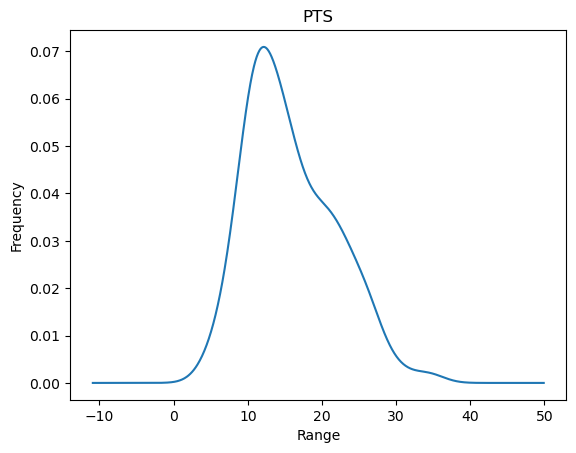

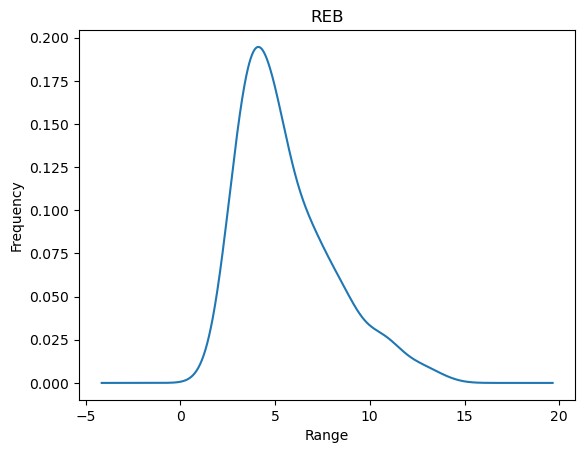

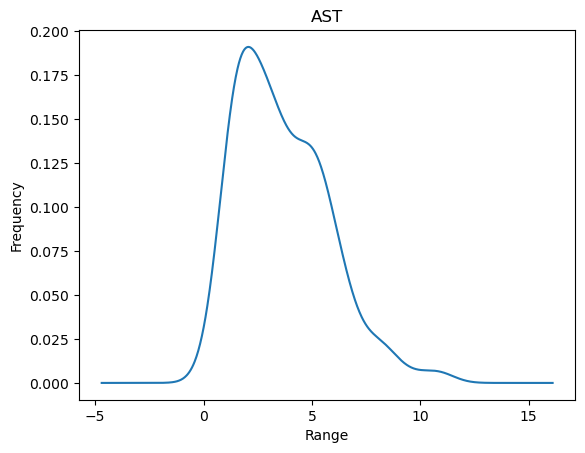

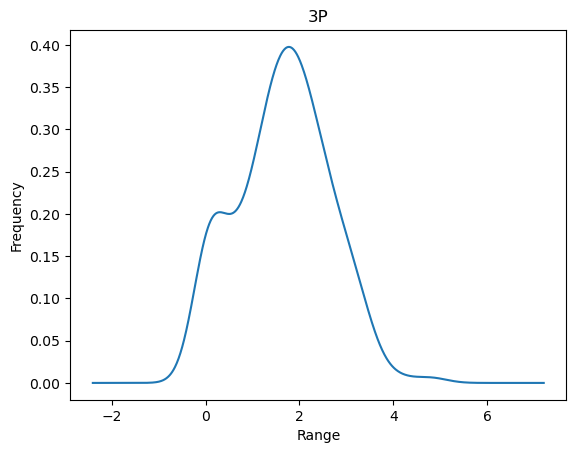

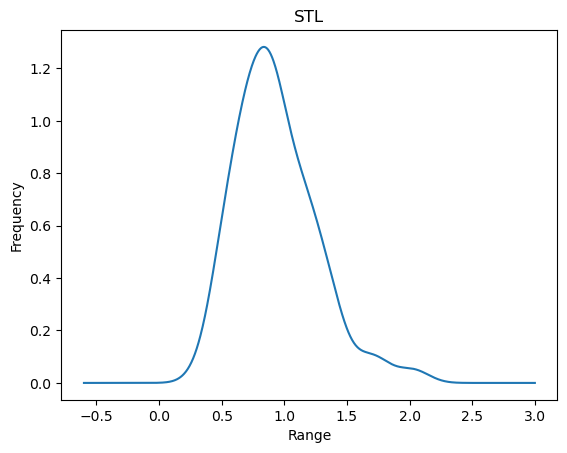

In [174]:
categorical_weights(df_top_200)

In [175]:
def MLR():
    
    # MLR method
    df_matchup = pd.read_csv('Yahoo_Matchup_List.csv')
    df_matchup = df_matchup.drop(["Team 1 ID", "Team 2 ID", "Playoff", "Consolation", "Complete", "Team 1 Name", "Team 2 Name", "Week", "Team 1 TO", "Team 2 TO", "Team 1 FG%", "Team 2 FG%", "Team 1 FT%", "Team 2 FT%", "Team 1 BLK", "Team 2 BLK"], axis=1)

    df_copy_1 = df_matchup[["Team 1 Points", "Team 1 3PTM", "Team 1 PTS", "Team 1 REB", "Team 1 AST", "Team 1 ST"]]
    df_copy_2 = df_matchup[["Team 2 Points", "Team 2 3PTM", "Team 2 PTS", "Team 2 REB", "Team 2 AST", "Team 2 ST"]]

    df_copy_1 = df_copy_1.rename(columns={"Team 1 Points": "Team Points", "Team 1 3PTM": "Team 3PTM", "Team 1 PTS": "Team PTS", "Team 1 REB": "Team REB", "Team 1 AST": "Team AST", "Team 1 ST": "Team ST"})
    df_copy_2 = df_copy_2.rename(columns={"Team 2 Points": "Team Points", "Team 2 3PTM": "Team 3PTM", "Team 2 PTS": "Team PTS", "Team 2 REB": "Team REB", "Team 2 AST": "Team AST", "Team 2 ST": "Team ST"})
    
    df_matchup = pd.concat([df_copy_1, df_copy_2], axis=0, ignore_index=True)
    
    print(df_matchup)
    
    y = df_matchup["Team Points"]
    X = df_matchup[["Team 3PTM", "Team PTS", "Team REB", "Team AST", "Team ST"]]
    
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    
    print('Intercept: \n', regr.intercept_)
    print('Coefficients: \n', regr.coef_)
    
    x = sm.add_constant(X)

    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 

    print_model = model.summary()
     
    MAE = metrics.mean_absolute_error(df_matchup["Team Points"], predictions)
    MSE = metrics.mean_squared_error(df_matchup["Team Points"], predictions)
    R2 = np.sqrt(metrics.mean_squared_error(df_matchup["Team Points"], predictions))
    
    print('Mean Absolute Error:', MAE)
    print('Mean Square Error:', MSE)
    print('Root Mean Square Error:', R2)
    print("\n")
    
    return

In [176]:
MLR()

     Team Points  Team 3PTM  Team PTS  Team REB  Team AST  Team ST
0              5         64       563       212       116       42
1              6         46       485       195       136       38
2              7         46       433       221        83       27
3              4         63       654       217       123       35
4              4         52       496       199       105       21
..           ...        ...       ...       ...       ...      ...
247            4         58       525       209       101       27
248            3         70       710       248       200       53
249            4         80       731       297       218       44
250            3         49       538       216       121       22
251            4         61       517       214       102       33

[252 rows x 6 columns]
Intercept: 
 1.0646977157606567
Coefficients: 
 [ 0.01215019  0.00152018  0.00257365 -0.00033497  0.02304029]
Mean Absolute Error: 1.3444389933657834
Mean Square Error: 2.6

In [177]:
def pca_weights(df_top_200):
    
    # PCA
    df_pca = df_top_200[["PTS", "TRB", "AST", "3P", "STL"]]
    
    X = df_pca.values
    
    # Perform PCA
    pca = PCA(n_components=1)
    pca.fit(X)

    # Weights
    weights = pca.components_[0]
    print("PCA Weights:", weights)
    
    return

In [178]:
pca_weights(df_top_200)

PCA Weights: [0.97129463 0.06747427 0.21458534 0.07599245 0.01456861]


In [179]:
def writing_to_csv(df_zscores_200):
    
    # PCA
    df_zscores_200["Total PCA"] = (0.97129463 * df_zscores_200["PTS Z-Score"] + 0.06747427 * df_zscores_200["TRB Z-Score"] + 0.21458534 * df_zscores_200["AST Z-Score"] + 0.07599245 * df_zscores_200["3P Z-Score"] + 0.01456861 * df_zscores_200["STL Z-Score"])*df_zscores_200["Average Games Played"]
    
    df_zscores_200 = df_zscores_200.sort_values(by='Total PCA', ascending=False, ignore_index=True)
    
    df_zscores_200.to_csv('PCA.csv', index=False)
    
    # MLR
    df_zscores_200["Total MLR"] = (0.00152018 * df_zscores_200["PTS Z-Score"] + 0.00257365 * df_zscores_200["TRB Z-Score"] + -0.00033497 * df_zscores_200["AST Z-Score"] + 0.01215019 * df_zscores_200["3P Z-Score"] + 0.02304029 * df_zscores_200["STL Z-Score"])*df_zscores_200["Average Games Played"]

    df_zscores_200 = df_zscores_200.sort_values(by='Total MLR', ascending=False, ignore_index=True)
    
    df_zscores_200.to_csv('MLR.csv', index=False) 
    
    # Yahoo Analysis
    df_zscores_200["Total Yahoo"] = (1.38 * df_zscores_200["PTS Z-Score"] + 1.3 * df_zscores_200["TRB Z-Score"] + 1.41 * df_zscores_200["AST Z-Score"] + 1.23 * df_zscores_200["3P Z-Score"] + 1.16 * df_zscores_200["STL Z-Score"])*df_zscores_200["Average Games Played"]

    df_zscores_200 = df_zscores_200.sort_values(by='Total Yahoo', ascending=False, ignore_index=True)
    
    df_zscores_200.to_csv('Yahoo.csv', index=False) 
    
    # NBA Analysis
    df_zscores_200["Total NBA"] = (1 * df_zscores_200["PTS Z-Score"] + 1.5 * df_zscores_200["TRB Z-Score"] + 1.5 * df_zscores_200["AST Z-Score"] + 1.25 * df_zscores_200["3P Z-Score"] + 1.25 * df_zscores_200["STL Z-Score"])*df_zscores_200["Average Games Played"]

    df_zscores_200 = df_zscores_200.sort_values(by='Total NBA', ascending=False, ignore_index=True)
    
    df_zscores_200.to_csv('NBA.csv', index=False) 
    
    return

In [180]:
writing_to_csv(df_zscores_200)

In [181]:
# Store the dataframes
%store df_top_200

Stored 'df_top_200' (DataFrame)
